# Joystick Transfer Functions

This notebook demonstrated the algorithms for joystick transfer functions used to transform joystick operator input to the system demand signal.

- Joystick Expo Scaling with Deadband
- Output Rate Limiting

In [11]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib notebook

## Joystick Expo Scaling with Deadband

**Expo scaling** provides finer demand control at low input values.

**Deadband** prevents a demand signal while the joystick is in its neutral postion.  This demand can be caused by minor mechanical misadjustments of the joystick.

Sample data, `ramp`, is a simulated joystick full-range movement producing an input signal `[-1.0, 1.0]`.

In [12]:
ramp = pd.DataFrame(data=np.arange(-1, 1, 0.01), index=np.arange(-1, 1, 0.01), columns=['default'])

The `expo(x)` function transforms input values to output values. Parameters affecting the expo curve are:

- `deadband` = the width of the input deadband
- `scale` = the curvature of the expo scaling

<IPython.core.display.Javascript object>


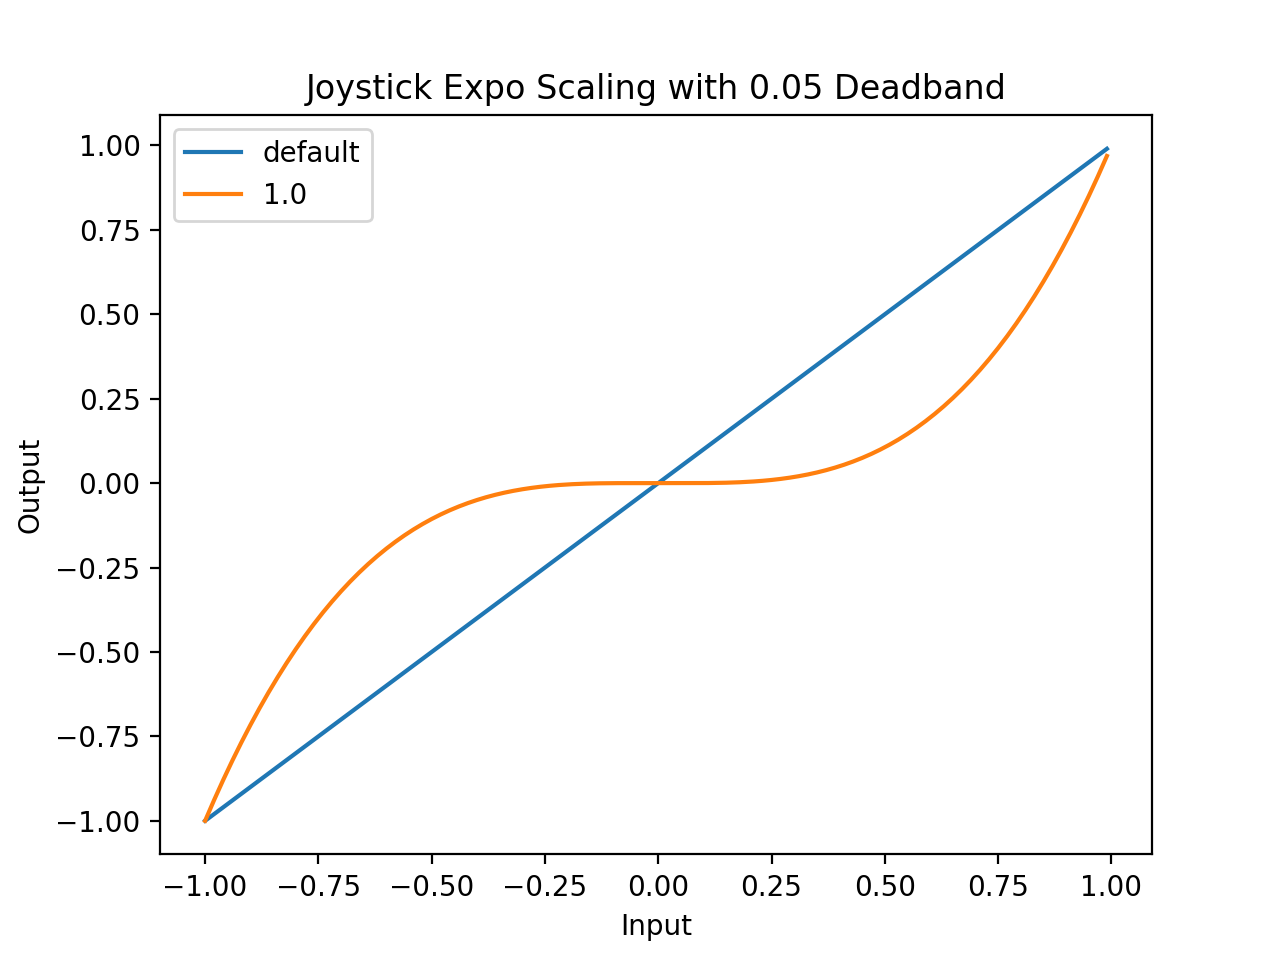

In [13]:
deadband = 0.05
scale = 1.0

# offset allows full range output [-1.0, 1.0] by compensating for deadband
offset = 1.0 / (scale * pow(1 - deadband, 3) + (1 - scale) * (1 - deadband))

def expo(x):
    if abs(x) < deadband:
        return 0
    y = x - deadband if x > 0 else x + deadband
    return (scale * pow(y, 3) + (1 - scale) * y) * offset

def plot_expo(df):
    ax = df.plot()
    plt.title("Joystick Expo Scaling with {} Deadband".format(deadband))
    plt.xlabel("Input")
    plt.ylabel("Output")

ramp[scale] = ramp['default'].apply(expo)

plot_expo(ramp)

## Output Rate Limiting

**Rate Limiting** limits the rate of change of output for inputs that exceed a threshold value.

Sample data, `step`, is a simulated joystick full-range step change input at time = 500 ms and a half-range step change at time = 2000 ms.

In [14]:
p1 = pd.DataFrame(data={"input":-1}, index=np.arange(0, 500, 20))
p2 = pd.DataFrame(data={"input":1}, index=np.arange(500, 2000, 20))
p3 = pd.DataFrame(data={"input":0}, index=np.arange(2000, 2500, 20))
step = p1.append([p2, p3])
step.index.name = "time"

The `limit(x)` function transforms input values to output values. Parameters affecting the limit are:

- `rate_limit` = the maximum change in output allowed

In [15]:
rate_limit = 0.04

def limit(x):
    if abs(x - limit.last) > rate_limit:
        y = limit.last + math.copysign(rate_limit, x - limit.last)
    else:
        y = x
    limit.last = y
    return y

limit.last = -1.0

def plot_limit(df):
    ax = df.plot()
    pct_per_sec = rate_limit / (20/1000) * 100
    plt.title("Rate Limiting at {}% Full Travel per sec".format(pct_per_sec))
    plt.xlabel("Time")
    plt.ylabel("Output")


            
step['output'] = step['input'].apply(limit)

With output rate limited at 200% full travel over a second, the output takes a full second to transition from -1 to 1 (200%).

<IPython.core.display.Javascript object>


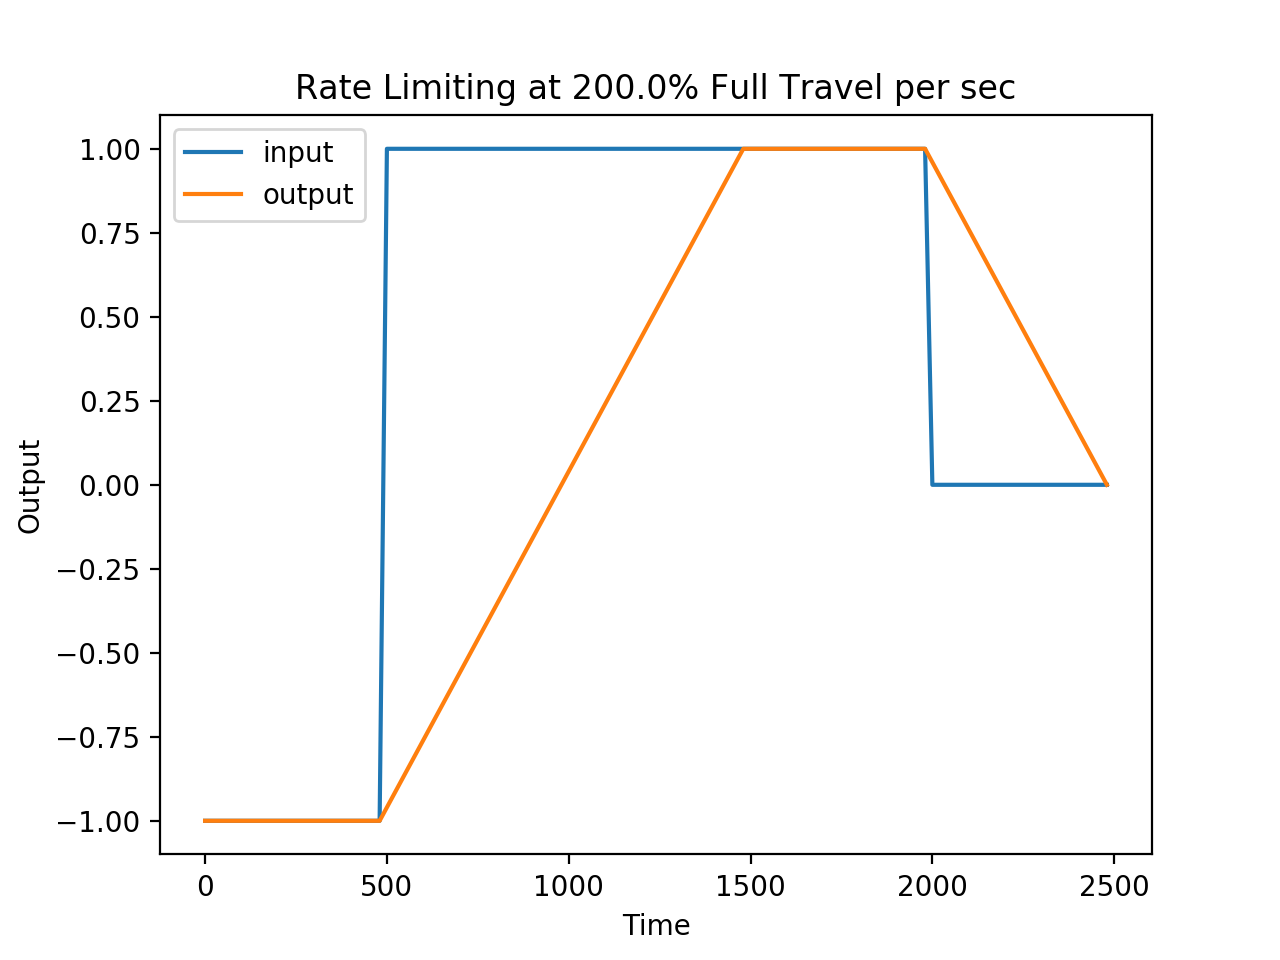

In [16]:
plot_limit(step)

In [17]:
w = 400

step = pd.DataFrame(data={"input":0}, index=np.arange(0, w, 20))
step.index.name = "time"

for seg in range(1, 5):
    input = 1 if seg % 2 else 0
    step = step.append(pd.DataFrame(data={"input":input}, index=np.arange(seg * w, (seg + 1) * w, 20))) 

limit.last = 0
step['output'] = step['input'].apply(limit)

With output rate limited at 200% full travel over a second, a step transition lasting 400 ms produces a 80% output transition.

<IPython.core.display.Javascript object>


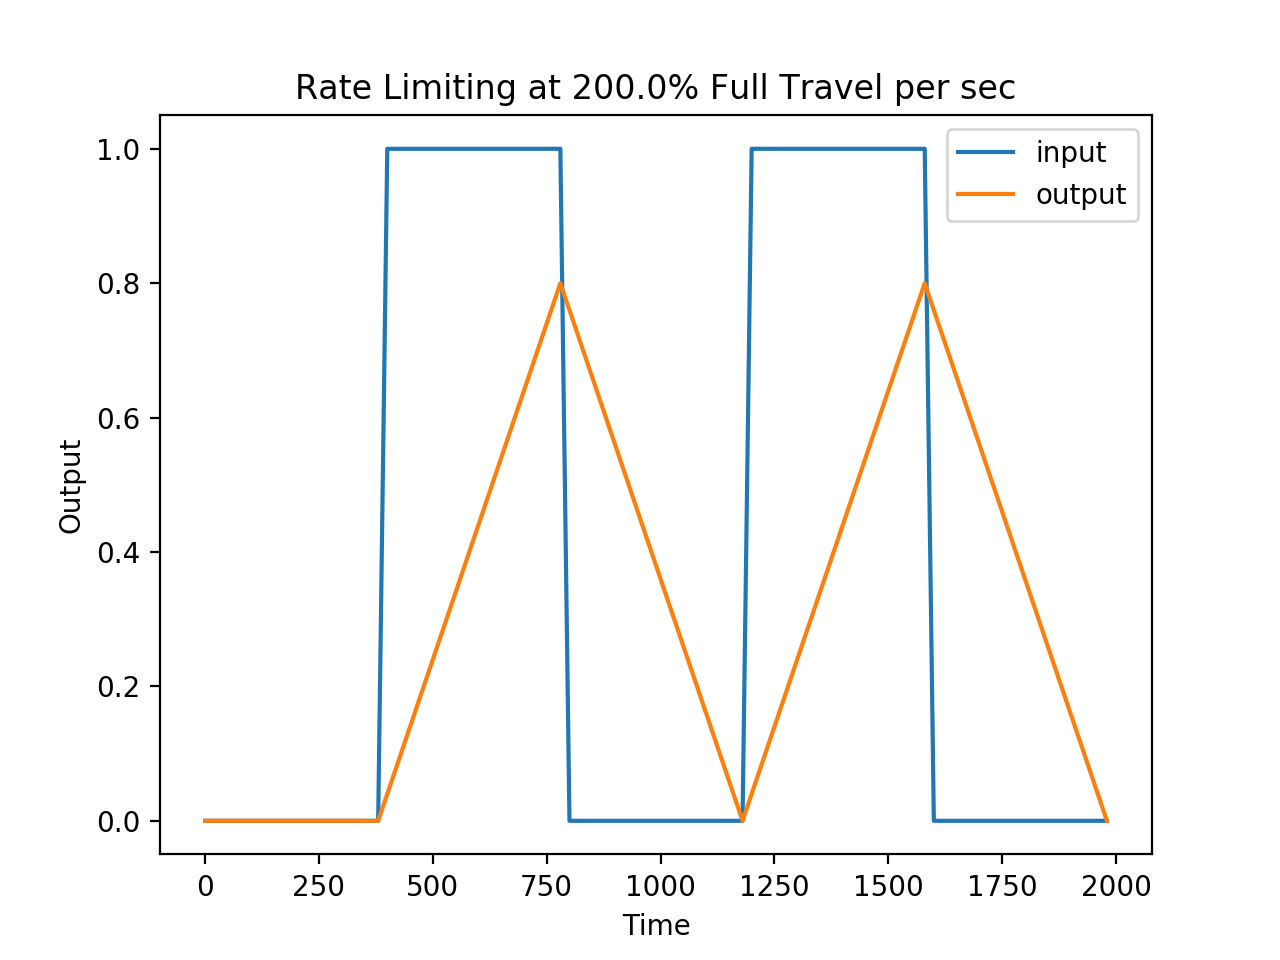

In [18]:
plot_limit(step)

Just for fun, a sine wave input with a 1,000 ms full throttle superimposed at 1,800 ms.

In [24]:
sine = pd.DataFrame(index=np.arange(0, 5000, 20))
sine['input'] = sine.index.map(lambda x: math.sin(math.radians(x/4)/3.5))
sine.loc[1800:2800, 'input'] = 1
limit.last = 0
sine['output'] = sine['input'].apply(limit)

<IPython.core.display.Javascript object>


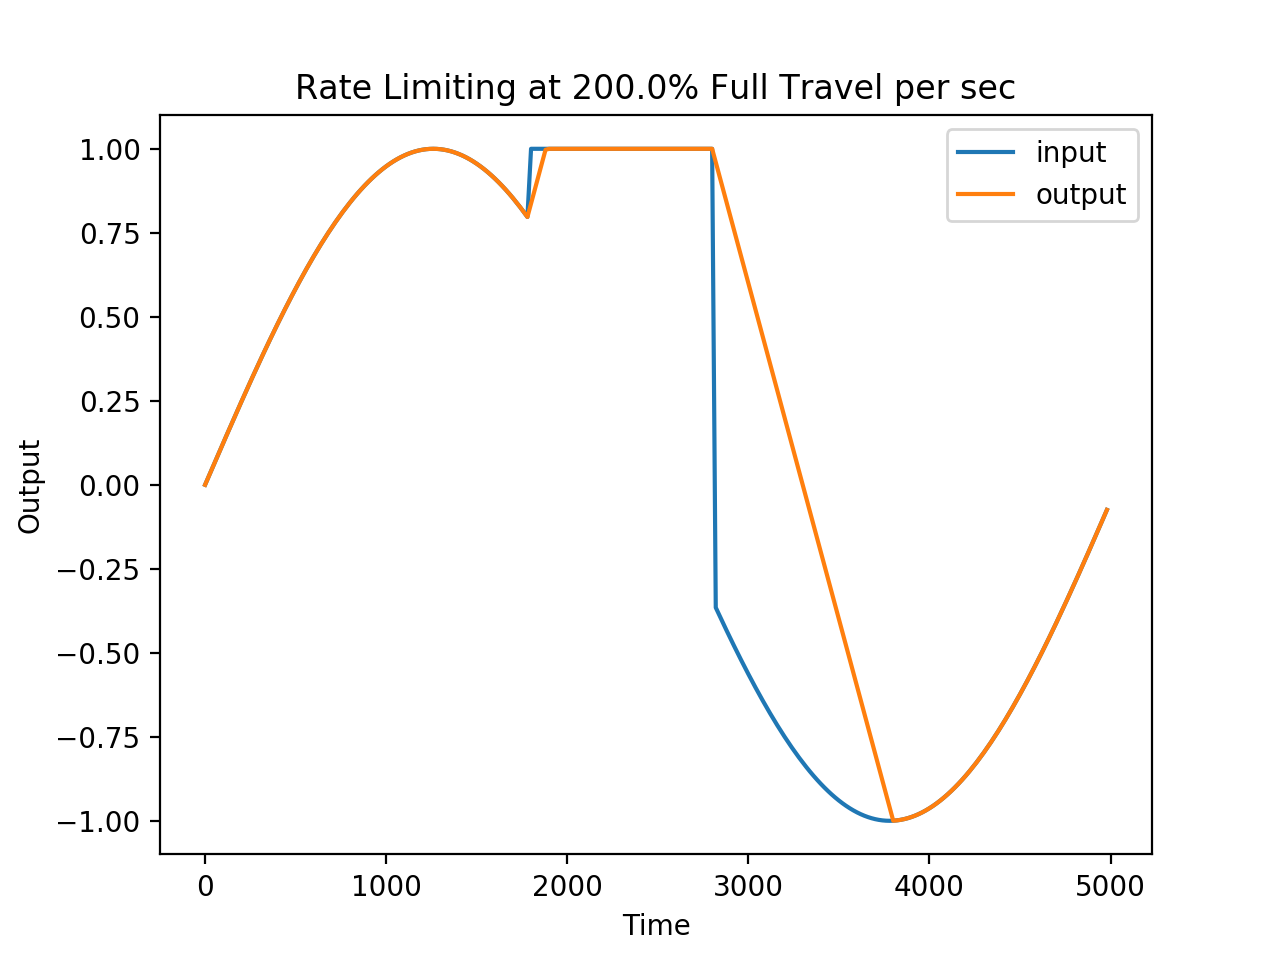

In [25]:
plot_limit(sine)